# Highly Parameterized Inversion

The current tutorial continues where the "freyberg glm part1" notebook left off. The "freyberg intro to model" and "freyberg pstfrom pest setup" pride details on the model and PEST dataset. The "freyberg obs and weights" and "freyberg glm 1" notebooks introduced changes to the PEST setup that are relevant to the current tutorial. You do not need to know the details of all these noteboks to follow along with general points of the current tutorial. 

In this tutorial we will add the final tweaks to a PEST dataset and then calibrate our model using PEST++GLM. Much like PEST, PEST++GLM undertakes highly parameterized inversion. However, it streamlines alot of the user-input process. It also automates FOSM and FOSM-based Monte Carlo uncertainty analyses. This drastically reduces requirements for user input, making workflows easier to implement. However, it also increases the number of moving pieces that a user must be familiar with (no free lunch!).

Here we will discuss some PEST++GLM specific options and their implications, calibrate the model and then explore outputs. 


### 1. Admin

Start off with the usual loading of dependencies and preparing model and PEST files. We will be continuing to work with the MODFLOW6 modified-Freyberg model (see "freyberg intro to model" notebook), and the high-dimensional PEST dataset prepared in the "freyberg glm 1" notebook. 


For the purposes of this notebook, you do not require familiarity with previous notebooks (but it helps...). Simply run the next few cells by pressing `shift+enter`.

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pyemu
import pandas as pd
import matplotlib.pyplot as plt;

import sys
sys.path.append("..")
# import pre-prepared convenience functions
import herebedragons as hbd

Specify the path to the PEST dataset template folder:

In [3]:
# specify the temporary working folder
t_d = os.path.join('freyberg6_template')

Copy across pre-prepared model and PEST files:

In [4]:
# use the convenience function to get the pre-preprepared PEST dataset;
# this continues off from the "freyberg glm 1" tutorial 
hbd.dir_cleancopy(org_d=os.path.join('..','..', 'models','freyberg_glm_1'), 
                new_d=t_d)

# get and unzip the prior covariance JCB file, prepared in "freyberg pstfrom" tutorial
hbd.unzip(os.path.join('..','..','models','prior_cov.zip'), os.path.join(t_d))

Files copied from:..\..\models\freyberg_glm_1
Files copied to:freyberg6_template


Right then, let's load in our PEST control file.

Just as a reminder, this is the control fle prepared in the "freyber glm 1" notebook:
 - We have reduced our very high dimensional PEST dataset down from 10s of thousands to several hundreds of parameters (#sad).
 - We continue to have lots os spatially distributed parameters (pilot points), which we expect to have a degree of spatial (and in some cases, temporal) correlation. 
 - We have also weighted observation groups so that they each contribute an equal amount to the intial objective function. 
 - We have already calculated a Jacobian matrix, with parameter sensitivities based on intial parameter values. 


In [212]:
pst = pyemu.Pst(os.path.join(t_d, 'freyberg_pp.pst'))

### Regularisation

We have an ill-posed inverse problem. The mathematical term for the process through which a unique solution is sought for a nonunique inverse problem is “regularisation”. The goal of regularised inversion is to seek a unique parameter field that results in a suitable fit between model outputs and field measurements, whilst minimizing the potential for wrongness in model predictions. That is, out of all the ways to fit a calibration dataset, regularized inversion seeks the parameter set of minimum error variance.

There are two main approaches used to stabilize this problem: (1) reducing the problem dimensionality and/or (2) adding soft knowledge. These methods can be used by themselves, but are most commonly applied together.



#### Tikhonov Regularisation (e.g. "soft knowledge")

One way to seek a parameter field of minimum error variance is to seek a parameter field that allows the model to fit the calibration dataset, but whose values are also as close as possible to a set of “preferred parameter values”. Ideally, preferred parameter values should also be initial parameter values as listed in the “parameter data” section of the PEST control file. These preferred parameter values are normally close to the centre of the prior parameter probability distribution. At the same time, scales and patterns of departures from the preferred parameter set that are required for model outputs to fit a calibration dataset should be achieved in ways that make “geological sense”.

PEST provides a user with a great deal of flexibility in how Tikhonov constraints can be introduced to an inversion process. The easiest way is to do this is through the use of prior information equations. When prior information equations are employed, Tikhonov constraints are expressed through preferred values that are assigned to linear relationships between parameters. In our case preferred values will be applied to the parameters themselves. (Equality is the simplest type of linear relationship.) Weights must be assigned to these equations. As is described in PEST documentation, when PEST is run in “regularisation” mode, it makes internal adjustments to the weights that are assigned to any observations or prior information equations that belong to special observation groups that are referred to as “regularisation groups”. 

#### Promoting "Geologicaly Reasonable" Patterns: Prior Information Equations vs Regularized-Gauss-Levenburg-Marquardt

PEST (and PEST_HP) provide the option to replace prior information equation weights with covariance matrices. When prior information equations embody Tikhonov constraints, they can be used to ensure that patterns of parameter heterogeneity that emerge from the inversion process are geologically reasonable. (See the GMDSI Tutorials for examples of how to accompish this with PEST_HP: https://gmdsi.org/blog/calibration-a-simple-model/)

PEST++GLM (which we will be using here) does things a bit differently. You *can* specify prior information equations and assign relevant weights. These weights may be calculated by the user accounting for geostatistical structure (e.g. first order pearson tikhonov) and explicitly assigned to the prior information equation. (See the "intro to pyemu" notebook for an example of how to do this).

Alternatively, PEST++GLM also offers users the option of using prior parameter covariance matrix based regularisation directly in the parameter upgrade calculation process. Instead of using the contribution of regularisation to the objective function to avoid "unrealistic" parameter patterns (as is done in PEST), this approach tries to maintain "realistic" patterns directly when calculating parameter upgrades. 

As we will show further on, this is implemented by specifying a prior parameter covariance matrix and the relevant `pest++` options. If this option is enabled, then prior information equation based regularisation cannot also be employed. Regularisation is controlled by the max singular values and eigen threshold control variables in the SVD section.

Pragmatically, the latter approach is the easier one to implement within a PEST++ workflow. A modeller will likley have already prepared a prior covariance marix. Thus ,only a few lines need to be added to the PEST control file.


In [ ]:
# do I want to demonstrate both???



In [220]:
par = pst.parameter_data
par.loc['pname:ghbhead_cn_inst:0_ptype:cn_usecol:3_pstyle:a', ['offset', 'parval1', 'parlbnd', 'parubnd']] = -10, 10, 8, 12

par.loc['pname:ghbhead_cn_inst:0_ptype:cn_usecol:3_pstyle:a']

parnme       pname:ghbhead_cn_inst:0_ptype:cn_usecol:3_pstyle:a
partrans                                                   none
parchglim                                              relative
parval1                                                    10.0
parlbnd                                                     8.0
parubnd                                                    12.0
pargp                                                ghbhead_cn
scale                                                       1.0
offset                                                    -10.0
dercom                                                        1
pname                                                   ghbhead
inst                                                          0
ptype                                                        cn
pstyle                                                        a
i                                                           NaN
j                                       

In [213]:
cov = pyemu.Cov.from_binary(os.path.join(t_d,"prior_cov.jcb"))
cov = cov.get(pst.adj_par_names)


In [214]:
cov.get_maxsing()

561

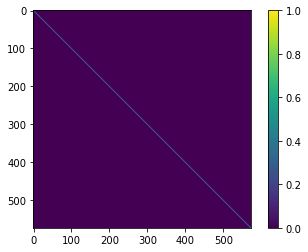

In [31]:
plt.imshow(dd.as_2d)
plt.colorbar()

In [55]:
md = os.path.join('master_glm_2')

In [139]:
Q = pyemu.Cov.from_observation_data(pst).inv

In [141]:
wel_future = [i for i in pst.adj_par_names if 'wel_cst' in i and int(i.split('_')[2].split(':')[-1]) > 12]


In [142]:
[i for i in pst.adj_par_groups if 'wel' in i], [i for i in jco_temp.col_names if 'wel' in i]

(['wel_cst'],
 ['pname:wel_cst_inst:0_ptype:cn_usecol:3_pstyle:m',
  'pname:wel_cst_inst:1_ptype:cn_usecol:3_pstyle:m',
  'pname:wel_cst_inst:2_ptype:cn_usecol:3_pstyle:m',
  'pname:wel_cst_inst:3_ptype:cn_usecol:3_pstyle:m',
  'pname:wel_cst_inst:4_ptype:cn_usecol:3_pstyle:m',
  'pname:wel_cst_inst:5_ptype:cn_usecol:3_pstyle:m',
  'pname:wel_cst_inst:6_ptype:cn_usecol:3_pstyle:m',
  'pname:wel_cst_inst:7_ptype:cn_usecol:3_pstyle:m',
  'pname:wel_cst_inst:8_ptype:cn_usecol:3_pstyle:m',
  'pname:wel_cst_inst:9_ptype:cn_usecol:3_pstyle:m',
  'pname:wel_cst_inst:10_ptype:cn_usecol:3_pstyle:m',
  'pname:wel_cst_inst:11_ptype:cn_usecol:3_pstyle:m',
  'pname:wel_cst_inst:12_ptype:cn_usecol:3_pstyle:m'])

In [180]:
jco = pyemu.Jco.from_binary(os.path.join(md, 'freyberg_pp.jcb'))

In [201]:
sel_cols = [i for i in pst.adj_par_names if i not in wel_future]
sel_cols = [i for i in sel_cols if 'ghbcond' not in i]
#sel_cols = [i for i in sel_cols if 'sfr' not in i]
#sel_cols = [i for i in sel_cols if 'wel' not in i]
#sel_cols = [i for i in sel_cols if 'rch' not in i]
sel_cols = [i for i in sel_cols if 'sto' not in i]

jco_temp = jco.get(col_names=sel_cols)
#jco_temp.col_names

In [202]:
[i for i in pst.adj_par_names if 'ghb' in i]

['pname:ghbcond_cn_inst:0_ptype:cn_usecol:4_pstyle:m',
 'pname:ghbhead_cn_inst:0_ptype:cn_usecol:3_pstyle:a']

In [203]:
[i for i in pst.adj_par_names if 'sto' in i]

['pname:sto_ss_layer2_cn_inst:0_ptype:cn_pstyle:m',
 'pname:sto_ss_layer3_cn_inst:0_ptype:cn_pstyle:m',
 'pname:sto_sy_layer1_cn_inst:0_ptype:cn_pstyle:m']

In [210]:
JTQJ = jco_temp.transpose * Q *jco_temp #+cov
JTQJ.inv.as_2d

array([[-3.41529673e+10, -6.75698168e+10,  5.50200344e+10, ...,
         3.78277760e+10,  7.10480773e+11, -3.33369502e+09],
       [ 4.02574584e+09, -4.95334143e+09,  7.39925017e+09, ...,
         6.94868107e+09,  7.83258154e+09, -7.09644101e+08],
       [-9.29545795e+08, -8.34528754e+09, -2.31670738e+08, ...,
        -1.81941922e+10,  7.88511289e+10, -2.46572477e+08],
       ...,
       [ 4.55227835e+10,  1.14878082e+10, -2.47667333e+10, ...,
         6.82891134e+10, -3.69301048e+11,  3.15207046e+09],
       [-2.49249800e+36,  5.56379956e+35, -1.07245788e+36, ...,
        -3.12659449e+34,  7.21340659e+53, -1.10664500e+35],
       [-2.88127920e+08,  5.34408962e+08,  1.18614194e+08, ...,
        -1.07161673e+09,  2.18415209e+09, -3.09148712e+07]])


### SVD

Unlike PEST, members of the PEST++ suite employ singular value decomposition (or methods closely related to it) for solution of the inverse problem by default. When using Regularized-Gauss-Levenburg-Marquardt (i.e. `glm_normal_form()` option), the MAXSING and EIGTHRESH control variables become the controling factors on regularisation.


### SVD-assist?
Use of PEST’s “SVD-assist” methodology can promulgate significant increases in the numerical efficiency of highly parameterized inversion. In implementing this methodology, PEST estimates the values of so-called “super parameters” in place of the parameters themselves. 

Estimation of super parameters can reduce the computational burden of highly parameterized inversion considerably. However, a Jacobian matrix based on the full parameter set must be calculated prior to commencement of the super parameter inversion process.

Unfortunately, the large computational savings accrued through SVD-assisted inversion are accompanied by a number of costs. Chief among these is that, for a nonlinear model, the partitioning of parameter space into solution and null spaces based on singular decomposition of a full Jacobian matrix calculated on the basis of initial parameter values may not remain valid as parameter values change. Hence, as the super parameter inversion process progresses, it may become necessary to recalculate a full Jacobian matrix so that super parameters can be re-defined. For moderately to highly nonlinear models, super parameter redefinition may be required every few iterations. With intermittent super parameter redefinition, model run savings accrued through SVD-assisted inversion may still be considerable; however, they will not be as great as for a linear model where re-computation of a full Jacobian matrix is never required.

### How many super parameters? 
see PEST amnual page 227

### FOSM informed NSMC 